In [2]:
from utils import *
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import warnings 

%load_ext autoreload 
%autoreload 2

# NOTE: The n_bottom_2024 transcriptome library is a bit on the small size. 

In [3]:
mp_genome_ids = ['mp_15', 'mp_1', 'mp_5', 'mp_12', 'mp_7', 'mp_4', 'mp_18', 'mp_16', 'mp_20'] # From sandbox-1.ipynb
# ref_gene_ids = {genome_id:df.gene_id.unique() for genome_id, df in pd.read_csv('ref_genes.csv', comment='#').groupby('genome_id')}

In [4]:
# First question to address is which genes are the most highly expressed in each strain and sample?
metat_df = metat_load(data_dir='../data/metat/').rename(columns={'length':'genome_size'})
metat_df['sample_id'] = metat_df.sample_id.str.replace('_metat', '')
coverm_df = coverm_load('../data/coverm/all.tsv', contig_sizes=contig_sizes)

agg_funcs = {'read_count':'sum', 'genome_size':'sum', 'library_size':'first', 'year':'first', 'location':'first', 'reactor':'first', 'detected':'mean'}
metat_agg_df = metat_df.groupby(['genome_id', 'sample_id']).agg(agg_funcs).reset_index()
metat_agg_df['rpkm'] = metat_agg_df.read_count / (metat_agg_df.genome_size / 1e3) / (metat_agg_df.library_size / 1e6)
metat_agg_df['sample_id'] = metat_agg_df.sample_id.str.replace('_metat', '')

interproscan_df = load_interproscan()
interproscan_df = interproscan_df[interproscan_df.e_value < 1e-5].copy()
interproscan_df['gene_id'] = interproscan_df['id']

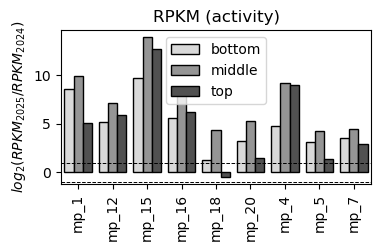

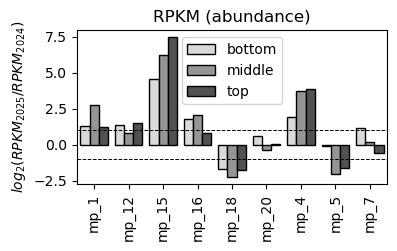

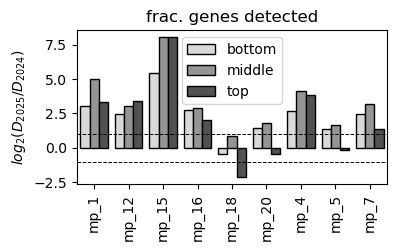

In [5]:
# Because of the compositional nature of the data, it is hard to distinguish between true zeros and sampling zeros, particularly
# in lowly-expressed genes. 

metric = 'RPKM'
metric = 'D'

def plot_fold_change(figure_df:pd.DataFrame, metric=metric, title='activity'):

    fig, ax = plt.subplots(figsize=(4, 2)) 

    figure_df = figure_df[(figure_df.reactor == 'n') & figure_df.genome_id.isin(mp_genome_ids)].copy()
    figure_df = figure_df.rename(columns={'rpkm':'RPKM', 'detected':'D'})
    figure_df = figure_df.pivot(index=['genome_id', 'location'], values=metric, columns='year')
    figure_df = figure_df.reset_index()
    figure_df[f'log2_{metric}_ratio'] = np.log2(figure_df['2025'] / figure_df['2024'])
    figure_df[f'log10_{metric}_2024'] = np.log10(figure_df['2024'])
    figure_df[f'log10_{metric}_2025'] = np.log10(figure_df['2025'])

    sns.barplot(figure_df, y=f'log2_{metric}_ratio', x='genome_id', hue='location', palette='Grays', ax=ax, edgecolor='black')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('$log_2(' + metric + '_{2025} / ' + metric + '_{2024})$')
    ax.set_xlabel('')
    ax.get_legend().set_title('')
    ax.axhline(1, ls='--', color='black', lw=0.7)
    ax.axhline(-1, ls='--', color='black', lw=0.7)
    ax.set_title(title)
    plt.show()
    return figure_df

plot_fold_change(metat_agg_df, title='RPKM (activity)', metric='RPKM')
plot_fold_change(coverm_df, title='RPKM (abundance)', metric='RPKM')
figure_df = plot_fold_change(metat_agg_df, metric='D', title='frac. genes detected')

# Focusing on mp_18: With filtering approaches (1) and (2), many housekeeping genes (e.g. Rbp11, Rbp2) seem to be up-regulated 
# substantially (top 5th percentile), which indicates to me that the CLR assumption may not hold (geometric mean is either too low in 
# 2025 or too high in 2024). This could be biological, if overall baseline expression is higher in 2025. This is supported by the observation that,
# even though RPKM increases, the fraction of the genome detected decreases. Conclusion is that CLR normalization will not work for mp_18. 



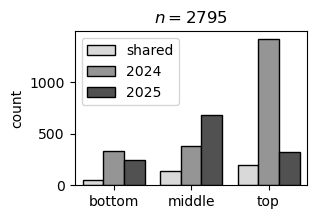

In [6]:
def plot_detected_genes(metat_df, genome_id:str='mp_18'):

    fig, ax = plt.subplots(figsize=(3, 2)) 

    get_n_shared_genes = lambda df : len(np.intersect1d(df[(df.year == '2024') & (df.read_count > 0)].gene_id.unique(), df[(df.year == '2025') & (df.read_count > 0)].gene_id.unique()))

    metat_df = metat_df[(metat_df.reactor == 'n') & (metat_df.genome_id == genome_id)].copy()

    figure_df = list()
    for location, df in metat_df.groupby('location'):
        figure_df.append({'category':'shared', 'n':get_n_shared_genes(df), 'location':location})
        figure_df.append({'category':'2024', 'n':((df.year == '2024') & (df.read_count > 0)).sum(), 'location':location})
        figure_df.append({'category':'2025', 'n':((df.year == '2025') & (df.read_count > 0)).sum(), 'location':location})
    figure_df = pd.DataFrame(figure_df)
    n_total = metat_df.gene_id.nunique()

    sns.barplot(figure_df, y='n', x='location', hue='category', palette='Grays', ax=ax, edgecolor='black')
    ax.set_xlabel('')
    ax.set_ylabel('count')
    ax.get_legend().set_title('')
    ax.set_title(f'$n={n_total}$')
    plt.show()

plot_detected_genes(metat_df)

In [7]:
def plot_gene_presence(figure_df:pd.DataFrame, title='ribosomal proteins', drop_empty:bool=True, figsize=(3, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    
    figure_df = figure_df[figure_df.reactor == 'n'].copy()
    figure_df = figure_df.pivot(columns='sample_id', values='read_count', index='annotation')
    figure_df.columns = figure_df.columns.str.replace('_metat', '')
    figure_df = figure_df.fillna(0).astype(int)
    if drop_empty:
        print(f'plot_gene_presence: Dropping {(figure_df.sum(axis=1).values.ravel() > 0).sum()} genes with no presence in any sample.')
        figure_df = figure_df[figure_df.sum(axis=1).values.ravel() > 0].copy()

    sns.heatmap(figure_df, annot=True, fmt='d', cmap='Grays', lw=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title)
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
    plt.show()

plot_gene_presence: Dropping 8 genes with no presence in any sample.


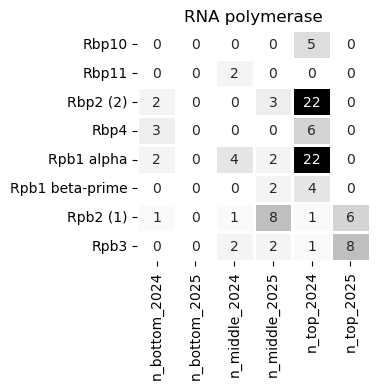

In [8]:
rnap_gene_ids = interproscan_df[interproscan_df.interpro_description.str.contains('RNA polymerase') & (interproscan_df.genome_id == 'mp_18')].gene_id.unique()

annotations = dict()
# annotations['mp_18.1_1024'] = 'DNA/RNA polymerase (1)'
annotations['mp_18.1_1331'] = 'Rpb3'
annotations['mp_18.1_1469'] = 'Rbp10'
annotations['mp_18.1_1470'] = 'Rbp6'
annotations['mp_18.1_1506'] = 'Rpb1 beta-prime'
annotations['mp_18.1_1507'] = 'Rpb1 alpha'
annotations['mp_18.1_1508'] = 'Rpb2 (1)'
annotations['mp_18.1_1509'] = 'Rbp2 (2)'
annotations['mp_18.1_1510'] = 'Rbp5'
annotations['mp_18.1_1766'] = 'Rbp4'
annotations['mp_18.1_211'] = 'Rbp11'
annotations['mp_18.1_220'] = 'transcription elongation factor Spt4'
annotations['mp_18.1_221'] = 'Rbp7'
# annotations['mp_18.1_2392'] = 'DNA/RNA polymerase (2)'
annotations['mp_18.1_2763'] = 'transcription factor S'
# annotations['mp_18.1_420'] = 'DNA/RNA polymerase (3)'
# annotations['mp_18.1_897'] = 'DNA/RNA polymerase (4)'

rnap_gene_ids = np.intersect1d(rnap_gene_ids, list(annotations.keys()))

mp_18_rnap_df = metat_df[metat_df.gene_id.isin(rnap_gene_ids)].copy()
mp_18_rnap_df['annotation'] = mp_18_rnap_df.gene_id.map(annotations)

plot_gene_presence(mp_18_rnap_df, title='RNA polymerase', figsize=(3, 3)) # Get those which are expressed somewhere. 
rnap_gene_ids = ['mp_18.1_1509', 'mp_18.1_1508', 'mp_18.1_1506', 'mp_18.1_1506', 'mp_18.1_1331', 'mp_18.1_1469', 'mp_18.1_211'] #, 'mp_18.1_420', 'mp_18.1_1024', 'mp_18.1_897']


In [9]:
# First want to identify how many ribosomal proteins are annotated in mp_18. This should be up on ggKbase. 
def load_ggkbase_gene_table(path:str, genome_id='mp_18'):
    # TODO: Will need to fix this function if more than one contig is present. 
    df = pd.read_csv(path, sep='\t', usecols=[0, 1, 2], names=['annotation', 'contig', 'features'], skiprows=1)

    df_ = list() # Kind of annoying but some of the genes are listed on the same line. 
    for row in df.itertuples():
        gene_ids = [gene_id.strip().split('_')[-1] for gene_id in row.features.split(',')]
        df_ += [{'gene_id':f'{genome_id}.1_{id_}', 'annotation':f'{row.annotation} ({i + 1})'} for i, id_ in enumerate(gene_ids)]
    df = pd.DataFrame(df_)
    df = df[['gene_id', 'annotation']].copy()
    return df 

mp_18_rp_df = load_ggkbase_gene_table('mp_18_ribosomal_proteins.txt')
mp_18_rp_df = mp_18_rp_df.merge(metat_df, on='gene_id', how='left')

mp_18_scg_df = load_ggkbase_gene_table('mp_18_archaeal_scg.txt')
# mp_18_scg_df = mp_18_scg_df.merge(metat_df, on='gene_id', how='left')

# plot_gene_presence(mp_18_scg_df)
# plot_gene_presence(mp_18_rp_df)


plot_gene_presence: Dropping 2 genes with no presence in any sample.


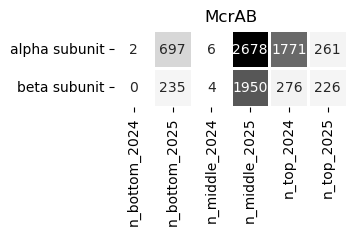

In [10]:
methanotrophy_accessions = pd.read_csv(f'../data/interpro_methanotrophy.csv', usecols=['accession']).accession.values 
methanotrophy_gene_ids = interproscan_df[interproscan_df.interpro_accession.isin(methanotrophy_accessions) & (interproscan_df.genome_id == 'mp_18')].gene_id.unique()

annotations = dict()
annotations['mp_18.1_1228'] = 'tetrapyrrole methylase'
annotations['mp_18.1_1407'] = 'pyridoxal phosphate-dependent transferase'
annotations['mp_18.1_1408'] = 'porphobilinogen deaminase'
annotations['mp_18.1_1409'] = 'uroporphyrin-III C-methyltransferase'
annotations['mp_18.1_1410'] = 'uroporphyrinogen III synthase (1)'
annotations['mp_18.1_1478'] = 'diphthine synthase'
annotations['mp_18.1_1649'] = 'precorrin methyltransferase'
annotations['mp_18.1_1651'] = 'cobalamin biosynthesis CobM/CbiF, precorrin-4 C11-methyltransferase'
annotations['mp_18.1_2107'] = 'delta-aminolevulinic acid dehydratase'
# annotations['mp_18.1_2147'] = 'methyl coenzyme M reductase, alpha subunit'
# annotations['mp_18.1_2150'] = 'methyl coenzyme M reductase, beta subunit'
annotations['mp_18.1_736'] = 'glutamyl-tRNA reductase'
annotations['mp_18.1_977'] = 'uroporphyrinogen III synthase (2)'

annotations['mp_18.1_2147'] = 'alpha subunit'
annotations['mp_18.1_2150'] = 'beta subunit'

mp_18_mcr_df = metat_df[metat_df.gene_id.isin(methanotrophy_gene_ids)].copy()
mp_18_mcr_df['annotation'] = mp_18_mcr_df.gene_id.map(annotations)

mcr_gene_ids = ['mp_18.1_2150', 'mp_18.1_2147']

plot_gene_presence(mp_18_mcr_df[mp_18_mcr_df.gene_id.isin(mcr_gene_ids)], title='McrAB', figsize=(3, 1))

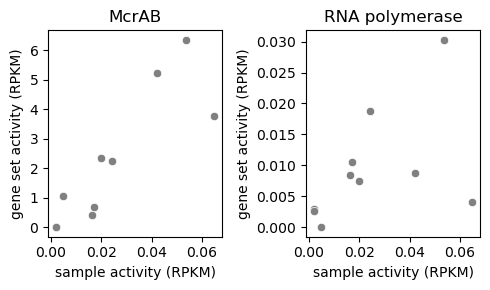

In [11]:


def plot_rpkm_correlation(gene_ids:list, genome_id:str='mp_18', ax=None, title:str=None):
    figure_df = metat_df[metat_df.gene_id.isin(gene_ids)].copy()
    figure_df = figure_df.groupby('sample_id').agg({'read_count':'sum', 'genome_size':'sum', 'library_size':'first'}).reset_index()
    figure_df['sample_rpkm'] = figure_df.sample_id.map(metat_agg_df[metat_agg_df.genome_id == genome_id].set_index('sample_id').rpkm)
    figure_df['rpkm'] = figure_df.read_count / (figure_df.genome_size / 1e3) / (figure_df.library_size / 1e6)
    sns.scatterplot(figure_df, x='sample_rpkm', y='rpkm', ax=ax, color='gray')
    ax.set_xlabel('sample activity (RPKM)')
    ax.set_ylabel('gene set activity (RPKM)')
    ax.set_title(title)
    return figure_df

fig, axes = plt.subplots(figsize=(5, 3), ncols=2)
plot_rpkm_correlation(mcr_gene_ids, ax=axes[0], title='McrAB')
plot_rpkm_correlation(rnap_gene_ids, ax=axes[1], title='RNA polymerase')
fig.tight_layout()
plt.show()

Num. 2024 genes in bottom with counts > 2: 215
Num. 2025 genes in bottom with counts > 2: 188
Num. 2024 genes in bottom with counts > 5: 34
Num. 2025 genes in bottom with counts > 5: 74
Num. 2024 genes in bottom with counts > 10: 3
Num. 2025 genes in bottom with counts > 10: 44
Num. 2024 genes in middle with counts > 2: 316
Num. 2025 genes in middle with counts > 2: 567
Num. 2024 genes in middle with counts > 5: 92
Num. 2025 genes in middle with counts > 5: 233
Num. 2024 genes in middle with counts > 10: 35
Num. 2025 genes in middle with counts > 10: 110
Num. 2024 genes in top with counts > 2: 1195
Num. 2025 genes in top with counts > 2: 272
Num. 2024 genes in top with counts > 5: 710
Num. 2025 genes in top with counts > 5: 96
Num. 2024 genes in top with counts > 10: 366
Num. 2025 genes in top with counts > 10: 43


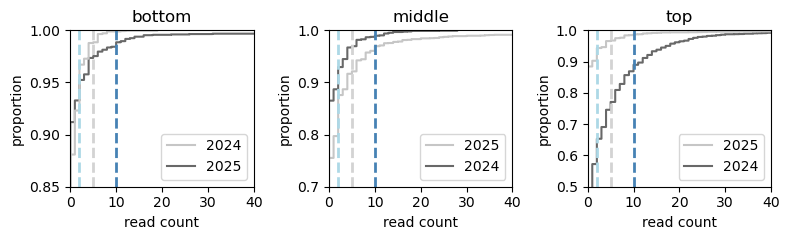

In [37]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))

figure_df = metat_df[(metat_df.genome_id == 'mp_18') & (metat_df.reactor == 'n')].copy()
# figure_df = figure_df[figure_df.read_count > 0].copy() # Consider only nonzero genes. 
# sns.kdeplot(figure_df, x='read_count', hue='sample_id', common_norm=False, palette='Grays')
x_mins = {'top':0.5, 'middle':0.7, 'bottom':0.85}
for ax, (location, df) in zip(axes, figure_df.groupby('location')):
    sns.ecdfplot(df, x='read_count', hue='year', palette='Grays', ax=ax)
    ax.set_xlim(xmin=0, xmax=40)
    ax.set_ylim(ymin=x_mins[location], ymax=1)
    ax.get_legend().set_title('')
    ax.set_ylabel('proportion')
    ax.set_xlabel('read count')
    ax.set_title(location)
    sns.move_legend(ax, loc='lower right')

    palette = {2:'lightblue', 5:'lightgray', 10:'steelblue'}
    for threshold, color in palette.items():
        ax.axvline(threshold, ls='--', color=color, lw=2)
        print(f'Num. 2024 genes in {location} with counts > {threshold}:', ((df.year == '2024') & (df.read_count >= threshold)).sum())
        print(f'Num. 2025 genes in {location} with counts > {threshold}:', ((df.year == '2025') & (df.read_count >= threshold)).sum())

fig.tight_layout()
plt.show()


In [ ]:
def get_diff(metat_df, location:str='bottom', reactor:str='n', genome_id=None, normalization='clr', ref_gene_ids=[], threshold=5):

    mask = ((metat_df.genome_id == genome_id) & (metat_df.reactor == reactor) & (metat_df.location == location))
    metat_df = metat_df[mask].copy()

    # metat_df = pd.concat([metat_filter(metat_df, threshold=20, min_samples=1), metat_filter(metat_df, threshold=1, min_samples=2)])
    metat_df = metat_filter(metat_df, threshold=threshold, min_samples=1)
    # if normalization == 'alr':
        # print(f'get_diff: {np.isin(ref_gene_ids, metat_df.gene_id.unique()).sum()} out of {len(ref_gene_ids)} reference genes retained after filtering.')
    # metat_df = metat_filter(metat_df, threshold=min_rpkm, min_samples=1)
    metat_df = metat_df.drop_duplicates(['gene_id', 'year'])
    metat_df = metat_normalize(metat_df, method=normalization, ref_gene_ids={genome_id:ref_gene_ids}, add_pseudocount='mzr')

    diff_df = dict()
    diff_df = {year:df.set_index('gene_id').sort_index() for year, df in metat_df.groupby('year')}

    diff_df = diff_df['2025'][['read_count_normalized']] - diff_df['2024'][['read_count_normalized']]
    diff_df = diff_df.reset_index().rename(columns={'read_count_normalized':'diff'})
    diff_df['genome_id'] = genome_id
    diff_df['location'] = location
    return diff_df


def plot_diff_distributions(locations=['bottom', 'middle', 'top'], threshold=5, quantile=None, genome_id='mp_18', axes=None, color='lightgray'):

    for ax, location in zip(axes, locations):
        figure_df = get_diff(metat_df, genome_id=genome_id, location=location, normalization='alr', ref_gene_ids=mcr_gene_ids, threshold=threshold)

        sns.kdeplot(figure_df, x='diff', common_norm=False, color=color, ax=ax, label=threshold)

        if quantile is not None:
            up_threshold = np.quantile(figure_df['diff'].values, 1 - quantile).item()
            down_threshold = np.quantile(figure_df['diff'].values, quantile).item()
            ax.axvline(up_threshold, ls='--', color='black', lw=0.7)
            ax.axvline(down_threshold, ls='--', color='black', lw=0.7)
        
        ax.set_ylabel('density')
        ax.set_title(location)
        

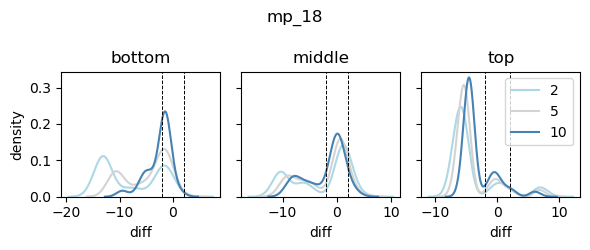

In [42]:

palette = {2:'lightblue', 5:'lightgray', 10:'steelblue'}
locations = ['bottom', 'middle', 'top']
fig, axes = plt.subplots(figsize=(2 * len(locations), 2.5), ncols=len(locations), sharey=True)

for threshold, color in palette.items():
    plot_diff_distributions(threshold=threshold, axes=axes, color=color)

axes[-1].legend()
for ax in axes:
    ax.axvline(2, ls='--', color='black', lw=0.7)
    ax.axvline(-2, ls='--', color='black', lw=0.7)

fig.suptitle('mp_18')
fig.tight_layout()
plt.show()

In [ ]:
diff_df = get_diff(metat_df, location='top', genome_id='mp_18', normalization='alr', ref_gene_ids=mcr_gene_ids)
diff_df = diff_df[np.abs(diff_df['diff']) < 2].copy()
diff_df = diff_df.merge(interproscan_df.drop(columns=['genome_id']), on='gene_id', how='left')
print('Num. genes co-regulated with mcrAB:', diff_df.gene_id.nunique())
print('Num. with no annotation:', diff_df[diff_df.signature_accession.isnull()].gene_id.nunique())
print('Num. with an InterPro description:', diff_df[(diff_df.interpro_description != '-') & (~diff_df.interpro_accession.isnull())].gene_id.nunique(), end='\n\n')

# for hmm, df in diff_df.groupby('signature_analysis', observed=True):
#     print(f'Num. with a {hmm} annotation:', df.gene_id.nunique())
diff_df = diff_df[['gene_id', 'location', 'diff', 'interpro_accession', 'interpro_description']].copy()
diff_df = diff_df.rename(columns={'interpro_accession':'accession', 'interpro_description':'annotation'})
diff_df = diff_df.drop_duplicates(['gene_id', 'accession'])
diff_df = diff_df[(diff_df.accession != '-') & (~diff_df.accession.isnull())].copy()

Num. genes co-regulated with mcrAB: 114
Num. with no annotation: 6
Num. with an InterPro description: 106



In [64]:
diff_df = get_diff(metat_df, location='top', genome_id='mp_18', normalization='alr', ref_gene_ids=mcr_gene_ids)
diff_df = diff_df[diff_df['diff'] > 3].copy()
diff_df = diff_df.merge(interproscan_df.drop(columns=['genome_id']), on='gene_id', how='left')
print('Num. genes up-regulated relative to mcrAB:', diff_df.gene_id.nunique())
print('Num. with no annotation:', diff_df[diff_df.signature_accession.isnull()].gene_id.nunique())
print('Num. with an InterPro description:', diff_df[(diff_df.interpro_description != '-') & (~diff_df.interpro_accession.isnull())].gene_id.nunique(), end='\n\n')

# for hmm, df in diff_df.groupby('signature_analysis', observed=True):
#     print(f'Num. with a {hmm} annotation:', df.gene_id.nunique())
diff_df = diff_df[['gene_id', 'location', 'diff', 'interpro_accession', 'interpro_description']].copy()
diff_df = diff_df.rename(columns={'interpro_accession':'accession', 'interpro_description':'annotation'})
diff_df = diff_df.drop_duplicates(['gene_id', 'accession'])
diff_df = diff_df[(diff_df.accession != '-') & (~diff_df.accession.isnull())].copy()

Num. genes up-regulated relative to mcrAB: 35
Num. with no annotation: 14
Num. with an InterPro description: 21



In [65]:
for gene_id, df in diff_df.groupby('gene_id'):
    print(gene_id)
    print('\n'.join(df.annotation))
    print()

mp_18.1_1046
Protein of unknown function with PCYCGC motif

mp_18.1_1122
P-loop containing nucleoside triphosphate hydrolase
Translational (tr)-type GTP-binding domain
GTP-eEF1A, C-terminal domain
Translation elongation factor EFTu-like, domain 2
Translation protein, beta-barrel domain superfamily
Translation elongation factor EF1A/initiation factor IF2gamma, C-terminal
Translation elongation factor EF1A, eukaryotic/archaeal
Small GTP-binding domain
Translation factor GTPase superfamily members

mp_18.1_1211
Armadillo-like helical
Armadillo-type fold

mp_18.1_1331
RNA polymerase, RBP11-like subunit
DNA-directed RNA polymerase, insert domain superfamily
DNA-directed RNA polymerase, RpoA/D/Rpb3-type
DNA-directed RNA polymerase, insert domain
Archaeal Rpo3/Eukaryotic RPB3 RNA Polymerase Subunit

mp_18.1_1405
ScdA-like, N-terminal domain superfamily

mp_18.1_1610
Protein of unknown function DUF2721

mp_18.1_1815
CBS domain superfamily
CBS domain
Diverse Function CBS-Domain-Containing Prote

In [14]:
# Want to plot the distribution of normalized ALR values... 

# fig, ax = plt.subplots(figsize=(5, 5))
# sample_id = 'n_bottom_2025_metat'
# figure_df = metat_df[metat_df.sample_id == sample_id].copy()
# sns.kdeplot(figure_df, hue='genome_id', x='read_count_normalized', common_norm=False, palette='Grays')
# ax.set_title(sample_id)

In [15]:
# First want to look at the metabolic potential of the genomes. What genes are present?
# Relevant metabolism things: (https://www.cell.com/trends/microbiology/fulltext/S0966-842X(25)00031-9)
# (1) Iron reduction (https://pmc.ncbi.nlm.nih.gov/articles/PMC7005843/)
# (2) Nitrate reduction
# (3) Humic acid reduction 
# (4) Methanotrophy 
# Denitrification (nitrate to nitrite) https://www.kegg.jp/module/M00529
# Might also be worth looking into genes for stress response. 



In [16]:

# Using the abundance data... In cases where RPKM is reasonably-high across years, it seems reasonable to assume that any zeros
# are true zeros, not sampling zeros. 
# print('Num. comparisons:', len(figure_df))
# min_rpkm = 10
# print(f'Num. comparisons with both RPKM > {min_rpkm}:', ((figure_df['2025'] > min_rpkm) & (figure_df['2024'] > min_rpkm)).sum())
# print()
# for row in figure_df[(figure_df['2025'] > min_rpkm) & (figure_df['2024'] > min_rpkm)].itertuples():
#     print(row.genome_id, row.location)

In [17]:
# For ALR reference genes, we want genes coupled to cell existence, but not things like growth rate, stress, etc. 
# https://www.frontiersin.org/journals/microbiology/articles/10.3389/fmicb.2019.02896/full uses infB, atpB, etc.
# https://omim.org/entry/138440 
# Seems like some transporter ATPases can be considered housekeeping genes https://pmc.ncbi.nlm.nih.gov/articles/PMC4513125/ 

In [18]:
# # Use HMMs from the FeGenie library to look for genes related to iron reduction. 
# hmmsearch_df = list()

# for path in glob.glob('../data/data/*.fa'):
#     genome_id = os.path.basename(path).replace('.fa', '')
#     output_path = f'../data/hmmsearch/{genome_id}-iron_reduction.tbl'
#     if not os.path.exists(output_path):
#         subprocess.run(f'hmmsearch --cpu 16 --tblout {output_path} ../data/hmms/iron_reduction.hmm {path} ', shell=True, check=True)
#     cols = ['query_id', 'query_description', 'target_id', 'target_decription', 'e_value', 'score', 'bias']
#     df = pd.read_csv(output_path, sep=r'\s+', comment='#', usecols=np.arange(len(cols)), names=cols)
#     if len(df) == 0:
#         continue
#     df['genome_id'] = genome_id
#     hmmsearch_df.append(df)

# hmmsearch_df = pd.concat(hmmsearch_df)
# hmmsearch_df = hmmsearch_df[is_mp(hmmsearch_df)].copy()
# hmmsearch_df = hmmsearch_df[hmmsearch_df.e_value < 1e-5].sort_values('e_value').copy()
# hmmsearch_df = hmmsearch_df.drop_duplicates(['genome_id', 'query_id'])

In [19]:
# interproscan_df[interproscan_df.signature_description.str.contains('nitrate|nitrite', case=False) & (interproscan_df.genome_id == 'mp_2')].sort_values('gene_id')
# interproscan_df[interproscan_df.signature_description.str.contains('iron', case=False) & (interproscan_df.genome_id == 'mp_1')].sort_values('gene_id')

# # These three proteins seem to exist in an operon. 
# # DMSO/Nitrate reductase chaperone (PF02613)
# # Nitrate reductase beta subunit (PTHR43518)
# # MopB Nitrate-R-NarG-like domain-containing protein (cd02750)

# # mp_5 14_65 14_66 14_63
# # mp_1 24_19 24_21 24_22
# # mp_4 74_3 74_4
# # mp_2 none
# # mp_3 231_6

# # https://pmc.ncbi.nlm.nih.gov/articles/PMC9295563/

In [20]:
# Reference set requirements (per organism):
# (1) At least one detected in each sample. 
# (2) Housekeeping genes. 

# genome_id = 'mp_15'
# metat_df_ = metat_df[metat_df.genome_id == genome_id].copy()
# metat_df_ = metat_df_[metat_df_.read_count > 0].copy()

# ref_genes_df = pd.DataFrame(metat_df_.groupby('gene_id').sample_id.nunique()).rename(columns={'sample_id':'n_samples'})
# ref_genes_df = ref_genes_df.sort_values('n_samples')
# ref_genes_df = ref_genes_df.reset_index()

# mask = (interproscan_df.interpro_accession != '-') & (~interproscan_df.duplicated(['gene_id', 'interpro_accession'], keep='first'))
# ref_genes_df = ref_genes_df.merge(interproscan_df[mask][['interpro_accession', 'interpro_description', 'gene_id']], on='gene_id', how='left')

# for gene_id, df in ref_genes_df[ref_genes_df.n_samples > 3].sort_values('n_samples').groupby('gene_id'):
#     for row in df.itertuples():
#         print(f'{genome_id},{row.gene_id},{row.n_samples},{row.interpro_accession},{row.interpro_description}')
#     print()

In [21]:
# Want to normalize based on some set of housekeeping genes, possibly the ribosomal proteins. 

# pattern = r'[a-z]*((L\d+)|(S\d+)|(P\d+))'
# get_ribosomal_protein = lambda description : re.search(pattern, description).group(0) if (re.search(pattern, description)) else None

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     mask = interproscan_df.signature_description.str.contains('ribosomal', case=False) 
#     # mask = mask & (interproscan_df.signature_accession != '-')
#     mask = mask & (interproscan_df.interpro_accession != '-')
#     mask = mask & (interproscan_df.gene_id.str.contains('mp_'))
#     mask = mask & ~interproscan_df.interpro_accession.duplicated(keep='first')
#     mask = mask & interproscan_df.signature_description.str.contains(pattern, regex=True)

# ref_protein_accessions = interproscan_df[mask].interpro_accession.unique()

In [22]:
# ref_metat_df = metat_df[is_mp(metat_df) & (metat_df.interpro_accession.isin(ref_protein_accessions))].copy()
# ref_metat_df = ref_metat_df.sort_values('e_value').drop_duplicates('gene_id')

# ref_gene_ids = list()
# for genome_id, df in ref_metat_df.groupby('genome_id'):
#     print(f'Num. ribosomal protein hits in {genome_id}:', len(df))
#     ref_gene_ids += df.gene_id.unique().tolist()
# ref_gene_ids = {genome_id:df.gene_id.unique() for genome_id, df in ref_metat_df[ref_metat_df.gene_id.isin(ref_gene_ids)].groupby('genome_id')}

# # The whole point of using ALR is to allow comparison across samples without relying on the assumption that the baseline level of 
# # expression is the same. I think the peaks of the diff_df values should line up at zero, so something is going on. Maybe need to do 
# # a better job of picking individual reference sets for each organism. 